<a href="https://colab.research.google.com/github/MtHenriqueF/Customer-segmentation-clustering/blob/Analise-exploratoria/clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introdução

Usaremos os arquivos CSV disponíveis em: [customer-segmentation](https://www.kaggle.com/datasets/kaushiksuresh147/customer-segmentation)

Esse dataset foi criado para classificação entre grupos A, B, C e D, porém utilizarei ele para aplicar modelo de clustering, segue uma breve descrição:


#### **Context**
An automobile company has plans to enter new markets with their existing products (P1, P2, P3, P4, and P5). After intensive market research, they’ve deduced that the behavior of the new market is similar to their existing market.

In their existing market, the sales team has classified all customers into 4 segments (A, B, C, D ). Then, they performed segmented outreach and communication for a different segment of customers. This strategy has work e exceptionally well for them. They plan to use the same strategy for the new markets and have identified 2627 new potential customers.

You are required to help the manager to predict the right group of the new customers.



# Carregando e configurando dataset

## Carregando

In [ ]:
import kagglehub
import pandas as pd
import os

path = kagglehub.dataset_download("kaushiksuresh147/customer-segmentation")

print("Path to dataset files:", path)

print("Arquivos disponíveis:")
print(os.listdir(path))


100%|██████████| 99.9k/99.9k [00:00<00:00, 30.6MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/kaushiksuresh147/customer-segmentation/versions/31
Arquivos disponíveis:
['Test.csv', 'Train.csv']


## Combinando treino e teste

In [ ]:
import pandas as pd
import os


train_path = os.path.join(path, "Train.csv")
test_path = os.path.join(path, "Test.csv")

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)



In [ ]:
print("--- Informações Iniciais ---")
print(f"Shape do df_train: {df_train.shape}")
print(f"Shape do df_test: {df_test.shape}")
print("\nColunas em Train.csv:")
print(df_train.columns)
print("\nColunas em Test.csv:")
print(df_test.columns)


--- Informações Iniciais ---
Shape do df_train: (8068, 11)
Shape do df_test: (2627, 11)

Colunas em Train.csv:
Index(['ID', 'Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1',
       'Segmentation'],
      dtype='object')

Colunas em Test.csv:
Index(['ID', 'Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1',
       'Segmentation'],
      dtype='object')


In [ ]:
df_combined = pd.concat([df_train, df_test], ignore_index=True)

print(f"Shape do df_combined: {df_combined.shape}")
print(f"Total de linhas esperado: {df_train.shape[0] + df_test.shape[0]}")


Shape do df_combined: (10695, 11)
Total de linhas esperado: 10695


## Removendo ID

ID é um péssimo atributo para qualquer modelo não supervisionado, pois não características de agrupamento que podem ser tiradas de um atributo que deve ser único para qualquer linha

In [ ]:
df = df_combined.drop("ID", axis=1)

In [ ]:
df

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A
...,...,...,...,...,...,...,...,...,...,...
10690,Male,No,29,No,Healthcare,9.0,Low,4.0,Cat_6,B
10691,Female,No,35,Yes,Doctor,1.0,Low,1.0,Cat_6,A
10692,Female,No,53,Yes,Entertainment,NaN,Low,2.0,Cat_6,C
10693,Male,Yes,47,Yes,Executive,1.0,High,5.0,Cat_4,C


## Removendo Target

Como o dataset original já era clusterizado, iremos tirar o agrupamento feito

In [ ]:
df = df.drop("Segmentation", axis=1)

# Analise exploratória

Uma breve análise exploratória para encontrar informações sobre as variáveis

In [ ]:
print("\nInformações gerais do DataFrame combinado:")
df.info()


Informações gerais do DataFrame combinado:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10695 entries, 0 to 10694
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           10695 non-null  object 
 1   Ever_Married     10505 non-null  object 
 2   Age              10695 non-null  int64  
 3   Graduated        10593 non-null  object 
 4   Profession       10533 non-null  object 
 5   Work_Experience  9597 non-null   float64
 6   Spending_Score   10695 non-null  object 
 7   Family_Size      10247 non-null  float64
 8   Var_1            10587 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 752.1+ KB


In [ ]:
df.describe()


,Age,Work_Experience,Family_Size
count,10695.000000,9597.000000,10247.000000
mean,43.511828,2.619777,2.844052
std,16.774158,3.390790,1.536427
min,18.000000,0.000000,1.000000
25%,30.000000,0.000000,2.000000
50%,41.000000,1.000000,3.000000
75%,53.000000,4.000000,4.000000
max,89.000000,14.000000,9.000000


In [ ]:
df.describe(include='object')


,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1
count,10695,10505,10593,10533,10695,10587
unique,2,2,2,9,3,7
top,Male,Yes,Yes,Artist,Low,Cat_6
freq,5841,6163,6570,3318,6494,6910


In [ ]:
df.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4
1,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6
4,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6


In [ ]:
print(df.isnull().sum())


Gender                0
Ever_Married        190
Age                   0
Graduated           102
Profession          162
Work_Experience    1098
Spending_Score        0
Family_Size         448
Var_1               108
dtype: int64


Muitos NaN's principalmente em Work_Experience que deverão ser preenchidos

In [ ]:
df.drop(['Age', 'Work_Experience'], axis=1).nunique()

,0
Gender,2
Ever_Married,2
Graduated,2
Profession,9
Spending_Score,3
Family_Size,9
Var_1,7


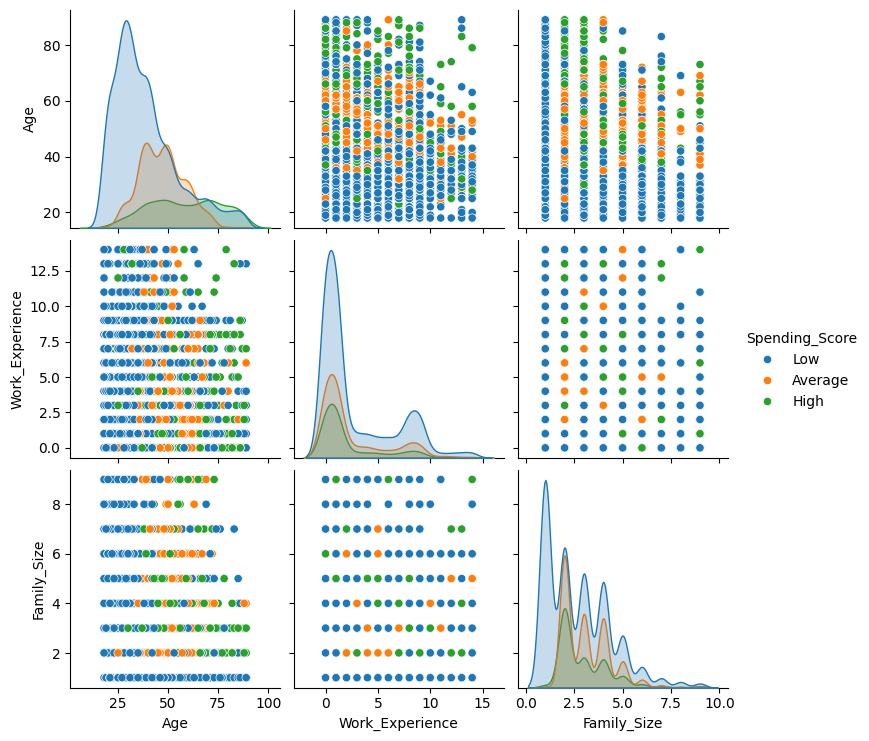

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df_numeric = df.select_dtypes(include=['Int64', 'int64'])

sns.pairplot(df, hue='Spending_Score', diag_kind='kde')
plt.show()

Existe um aglomeramento de valores em Work_experience entre 0 e 2.5

Distribuição dos valores únicos nas colunas:

Valores únicos em Gender:
Gender
Male      5841
Female    4854
Name: count, dtype: int64 



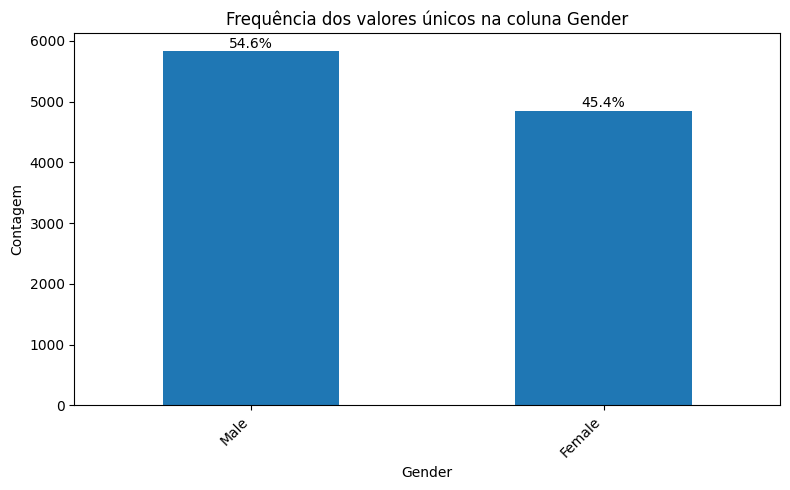

Valores únicos em Ever_Married:
Ever_Married
Yes    6163
No     4342
Name: count, dtype: int64 



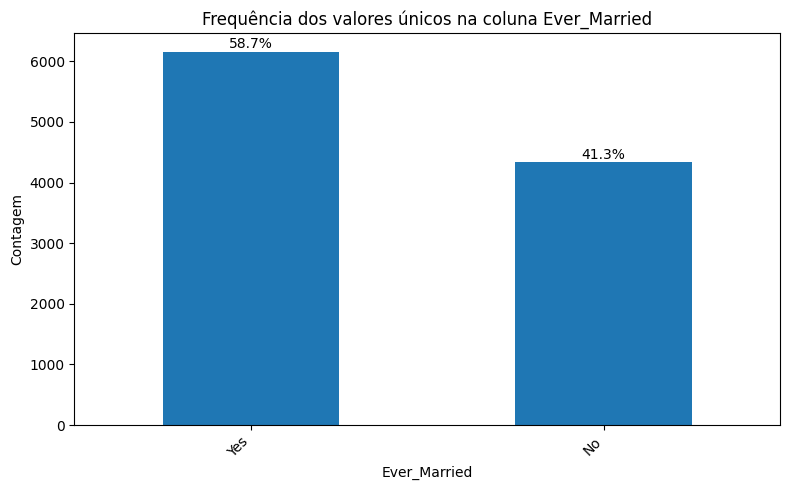

Valores únicos em Graduated:
Graduated
Yes    6570
No     4023
Name: count, dtype: int64 



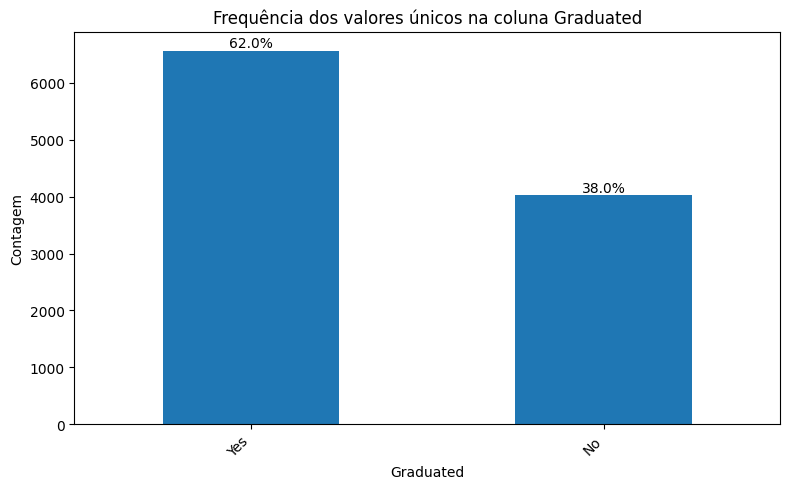

Valores únicos em Profession:
Profession
Artist           3318
Healthcare       1750
Entertainment    1250
Engineer          935
Doctor            930
Lawyer            844
Executive         775
Marketing         403
Homemaker         328
Name: count, dtype: int64 



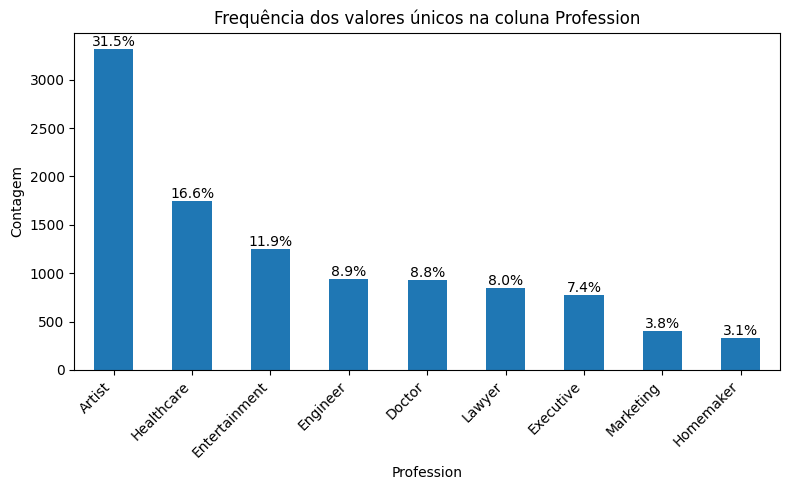

Valores únicos em Spending_Score:
Spending_Score
Low        6494
Average    2599
High       1602
Name: count, dtype: int64 



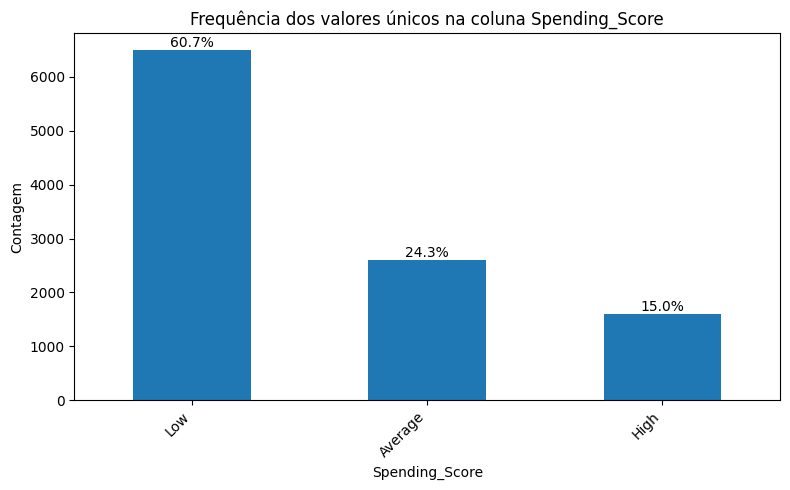

Valores únicos em Var_1:
Var_1
Cat_6    6910
Cat_4    1475
Cat_3    1089
Cat_2     563
Cat_7     269
Cat_1     167
Cat_5     114
Name: count, dtype: int64 



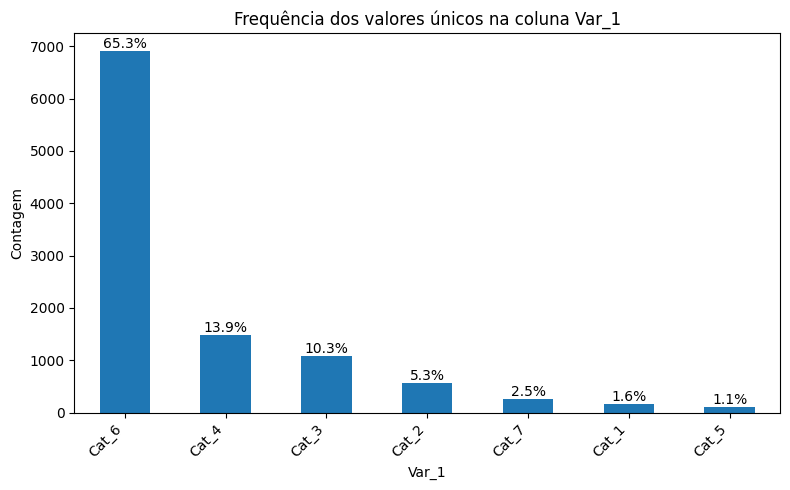

In [ ]:
import matplotlib.pyplot as plt

categorical_cols = df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    counts = df[col].value_counts()
    percents = df[col].value_counts(normalize=True) * 100

    print(f"Valores únicos em {col}:")
    print(counts, "\n")

    plt.figure(figsize=(8,5))
    counts.plot(kind='bar')

    # Adiciona porcentagens acima das barras
    for i, (count, percent) in enumerate(zip(counts, percents)):
        plt.text(i, count + 0.5, f'{percent:.1f}%', ha='center', va='bottom')

    plt.title(f'Frequência dos valores únicos na coluna {col}')
    plt.xlabel(col)
    plt.ylabel('Contagem')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


Podemos perceber que em alguns atributos, existem valores que são raramente encontrados, principalmente em profession e em var_1. Isso pode afetar o agrupamento, então talvez seja necessario absorver algum valor em outro. Como Var_1 é categórica e não temos conhecimento suficiente de como funciona essa variável, não me arriscarei a agrupar ela. Profession por outro lado não é categórica, é nominal, portanto, tentarei unir marketing e homemaker em uma nova categoria "outros".

In [39]:
categorias_para_agrupar = ["Marketing", "Homemaker"]

df["Profession_agrupada"] = df["Profession"].replace(categorias_para_agrupar, "Outros")

print(df["Profession_agrupada"].value_counts(normalize=True) * 100)


Profession_agrupada
Artist           31.500997
Healthcare       16.614450
Entertainment    11.867464
Engineer          8.876863
Doctor            8.829393
Lawyer            8.012912
Executive         7.357828
Outros            6.940093
Name: proportion, dtype: float64


# Pre processamento

O que será feito:
- Normalização;
- Preenchimento de missing values;
- Remoção de outliers

Como Work_Experience e Family_Size não são inteiros, converteremos float para inteiro

In [ ]:
df['Work_Experience'] = df['Work_Experience'].astype('Int64')
df['Family_Size'] = df['Family_Size'].astype('Int64')

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10695 entries, 0 to 10694
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Gender           10695 non-null  object
 1   Ever_Married     10505 non-null  object
 2   Age              10695 non-null  int64 
 3   Graduated        10593 non-null  object
 4   Profession       10533 non-null  object
 5   Work_Experience  9597 non-null   Int64 
 6   Spending_Score   10695 non-null  object
 7   Family_Size      10247 non-null  Int64 
 8   Var_1            10587 non-null  object
dtypes: Int64(2), int64(1), object(6)
memory usage: 773.0+ KB
None


## Preenchendo Nan's

### Técnica 1 - RandomForestClassifier



### Técnica 2 - Média

### Técnica 3 - KnnImputer

## Remoção de Outliers

### Técnica 1 - IQR

### Técnica 2 - Z score

## Técnica 3 - Manter os outliers

# Conclusão